In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import time

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

## Strategy Evaluation

In [3]:
def strategy_calculation(df, date_col='Date', signal_col='Combined Signal', price_col='Price', strategy='long_only'):
    """
    Calculate strategy-related columns based on the selected trading strategy without setting Date as the index initially.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing columns for date, signal, and price.
    date_col (str): Column name for dates.
    signal_col (str): Column name for trading signals (1 for long, -1 for short).
    price_col (str): Column name for prices.
    strategy (str): Either 'long_only', 'short_only', or 'long_short'. Determines the trading strategy.

    Returns:
    pd.DataFrame: DataFrame with additional columns for 'Price Return', 'Price Cum Return',
                  'Strategy Return', 'Strategy Cum Return', 'High Watermark', 'Drawdown', and 'Max Drawdown'.
    """
    # Calculate log returns for prices
    df['Price Return'] = np.log(df[price_col] / df[price_col].shift(1)).fillna(0)

    # Calculate cumulative return of the price itself (Price Cum Return)
    df['Price Cum Return'] = df['Price Return'].cumsum().apply(np.exp)

    # Use shifted signal directly based on the strategy
    if strategy == 'long_only':
        shifted_signal = df[signal_col].shift(1).apply(lambda x: 1 if x == 1 else 0)
    elif strategy == 'short_only':
        shifted_signal = df[signal_col].shift(1).apply(lambda x: -1 if x == -1 else 0)
    elif strategy == 'long_short':
        shifted_signal = df[signal_col].shift(1)

    # Calculate strategy return based on shifted signal
    df['Strategy Return'] = df['Price Return'] * shifted_signal # OK

    # Calculate cumulative return based on strategy return (Strategy Cum Return)
    df['Strategy Cum Return'] = df['Strategy Return'].cumsum().apply(np.exp)

    # Calculate high watermark and drawdown based on strategy cumulative return
    df['High Watermark'] = df['Strategy Cum Return'].cummax()
    df['Drawdown'] = (df['Strategy Cum Return'] - df['High Watermark']).clip(upper=0)
    df['Max Drawdown'] = df['Drawdown'].cummin()

    # Set the Date column as the index at the end
    df.set_index(date_col, inplace=True)

    return df

## Extracting sample data

In [5]:
def strategy_metrics(df, date_col='Date', signal_col='Combined Signal', price_col='Price', 
                     strategy='long_only', drawdown='max', timeframe = 1):
    """
    Extended version of strategy_calculation to compute and print additional metrics: Sharpe, CAGR, Max Drawdown, 
    and Drawdown Period (either max historical or ongoing drawdown).
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing date, signal, and price columns.
    - date_col (str): Name of the date column.
    - signal_col (str): Name of the trading signal column.
    - price_col (str): Name of the price column.
    - strategy (str): Trading strategy ('long_only', 'short_only', 'long_short').
    - drawdown (str): Type of drawdown period to calculate ('max' for historical max, 'current' for ongoing).
    - timeframe (int): Dynamic parameter to work with different time frame (e.g. daily data = 1; 2D = 0.5; half-day = 2...)
    
    Returns:
    - df (pd.DataFrame): DataFrame with strategy metrics columns.
    """
    # Call strategy_calculation to compute base strategy metrics
    df = strategy_calculation(df, date_col, signal_col, price_col, strategy)

    # Calculate periods per year to annualize Sharpe
    periods_per_year = 252 * timeframe # e.g. if data is half day then we have 504 periods per year
    
    # Calculate Sharpe Ratio (annualized, using 252 trading days)
    sharpe_ratio = np.sqrt(periods_per_year) * (df['Strategy Return'].mean() / df['Strategy Return'].std())

    # Calculate CAGR (annualized, using 365 days because we still bear opportunity cost for non-trading days)
    days_in_period = (df.index[-1] - df.index[0]).days
    cagr = df['Strategy Cum Return'].iloc[-1] ** (365 * timeframe/ days_in_period) - 1
    # 365 * timeframe equals to total number of periods per year based on the timeframe of the data, then divide by total days give 1/T

    # Calculate the maximum drawdown value
    max_drawdown = df['Max Drawdown'].min()

    # Drawdown period calculation based on the `drawdown` parameter
    if drawdown == 'current' and df['Drawdown'].iloc[-1] < 0:
        # Ongoing drawdown: calculate from last peak to current date
        drawdown_period = df.index[-1].to_pydatetime() - df['Drawdown'][df['Drawdown'] == 0].index[-1].to_pydatetime()
        drawdown_period_type = "Ongoing Drawdown Period (to current date)"
    else:
        # Historical max drawdown period: calculate between two consecutive zero drawdowns
        drawdown_periods = (
            df['Drawdown'][df['Drawdown'] == 0].index[1:].to_pydatetime() -
            df['Drawdown'][df['Drawdown'] == 0].index[:-1].to_pydatetime()   )
        drawdown_period = drawdown_periods.max()
        drawdown_period_type = "Longest Drawdown Period"

    # Print the calculated metrics
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"{drawdown_period_type}: {drawdown_period}")

In [6]:
def tickers_yf(tickers, start, end):
    """
    Using yfinance to download price data of tickers.
    
    Parameters:
    - tickers (list): List of tickers
    - start, end: Time horizon
    
    Returns:
    - df: Concatenated data of all tickers as MultiIndex
    """
    
    def data(ticker):
        try:
            return yf.download(ticker, start=start, end=end)
        except Exception as e:
            print(f"Could not download data for {ticker}: {e}")
            return None
    
    # Apply `data` function and filter out any None results
    interim_data = [d for d in map(data, tickers) if d is not None]
    
    # Concatenate and return as a multi-index DataFrame
    if interim_data:
        return pd.concat(interim_data, keys=tickers, names=['Tickers', 'Date'])
    else:
        print("No data downloaded.")
        return pd.DataFrame()  # Return empty DataFrame if no data was downloaded

In [7]:
concat_df = (
    tickers_yf(['IBM','WMT'], dt.datetime(2014, 10, 13), dt.datetime(2022, 9, 14)))
concat_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close  \
Tickers Date                                                         
IBM     2014-10-13  177.332703  178.441681  175.353729  175.449326   
        2014-10-14  176.759079  177.552582  175.516251  175.717010   
        2014-10-15  174.435944  175.707458  170.889099  173.757172   
        2014-10-16  171.892929  173.499039  170.831741  171.931168   
        2014-10-17  173.269592  174.799240  172.294449  174.043976   
...                        ...         ...         ...         ...   
WMT     2022-09-07   44.353333   45.323334   44.246666   45.246666   
        2022-09-08   45.133331   45.623333   44.959999   45.476665   
        2022-09-09   45.433334   45.833332   45.376667   45.613335   
        2022-09-12   45.693333   46.083332   45.656666   46.023335   
        2022-09-13   45.619999   45.983334   44.936668   45.073334   

                     Adj Close    Volume  
Tickers Date                              
IBM     2014-10-13  114.104881   3762148  
        2014-10-14  114.278946   4105236  
        2014-10-15  113.004379   7213007  
        2014-10-16  111.816849   5835216  
        2014-10-17  113.190887   4550309  
...                        ...       ...  
WMT     2022-09-07   43.970848  17058900  
        2022-09-08   44.194363  16956000  
        2022-09-09   44.327171  16140600  
        2022-09-12   44.725616  14284500  
        2022-09-13   43.802402  17687400  

[3988 rows x 6 columns]

In [8]:
df = (
    concat_df[['Adj Close']]
    .reset_index()
    .pivot(index = 'Date',
          columns =  'Tickers',
          values = 'Adj Close')
)
df

Tickers,IBM,WMT
Date,,
2014-10-13,114.104881,21.094612
2014-10-14,114.278946,21.208851
2014-10-15,113.004379,20.452749
2014-10-16,111.816849,20.077414
2014-10-17,113.190887,20.153570
...,...,...
2022-09-07,116.953552,43.970848
2022-09-08,117.649536,44.194363
2022-09-09,118.308899,44.327171


## Using `WMT` for the Price-MA Crossover Strategy

In [10]:
def sma_price_signals(price, sma_window, plot=False, plot_window=None, strategy='long_short', name='Ticker'):
    """
    Generate buy/sell signals based on the relationship between the current price and a moving average (SMA).
    Optionally, plot the closing prices and signal regions on a dual-axis plot.

    Parameters:
    price (pd.Series): The input series of prices.
    sma_window (int): The window size for calculating the SMA.
    plot (bool): If True, displays the plot with signal regions.
    plot_window (int, optional): Number of recent values to plot. If None, plots all values.
    fill_signals (str): 'long' for buy signals only, 'short' for sell signals only,
                        'long_short' for both buy and sell signals, or False to disable shading.
    name (str): Name for the series, used in labeling.

    Returns:
    pd.Series: A Series with 1 for buy signals, -1 for sell signals, and 0 otherwise.
    """
    # Calculate the SMA
    sma = price.rolling(window=sma_window).mean() # can re-use for other types of MA

    # Generate signals: 1 for buy, -1 for sell
    signals_series = pd.Series(
        np.where(price > sma, 1, -1),
        index=price.index,
        name=f'{name}_Signal')

    # Plotting if plot=True
    if plot:
        # Define the plotting range based on plot_window
        plot_data = price if plot_window is None else price[-plot_window:]
        plot_sma = sma if plot_window is None else sma[-plot_window:]
        plot_signals = signals_series if plot_window is None else signals_series[-plot_window:]

        # Plot closing price and SMA
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(plot_data, label=f'{name} Price', color='blue', alpha=0.7)
        ax.plot(plot_sma, label=f'SMA({sma_window})', color='orange')

        # Secondary y-axis for signals
        ax2 = ax.twinx()
        ax2.plot(plot_signals, color='purple', linestyle='--', label='Signals', alpha=0.7)
        ax2.set_ylim([-1, 1])  # Limits for signals (-1, 0, 1)

        # Shade regions based on the `fill_signals` parameter
        if strategy == 'long_short' or strategy == 'long':
            ax.fill_between(plot_data.index, plot_data.min(), plot_data.max(),
                            where=(plot_signals > 0), color='green', alpha=0.1, label='Long Zone')
        if strategy == 'long_short' or strategy == 'short':
            ax.fill_between(plot_data.index, plot_data.min(), plot_data.max(),
                            where=(plot_signals < 0), color='red', alpha=0.1, label='Short Zone')

        # Remove the plot borders (spines)
        for spine in ax.spines.values():
            spine.set_visible(False)
        for spine in ax2.spines.values():
            spine.set_visible(False)

        # Titles and labels
        plt.title(f'{name} Long/Short Zones with SMA({sma_window})', fontsize=14, color = 'darkred')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Price', fontsize=12)
        ax2.set_ylabel('Signal', fontsize=12)

        # Add legend and grid
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.show()

    return signals_series

In [11]:
wmt = df[['WMT']]
wmt.head(3)

Tickers,WMT
Date,
2014-10-13,21.094612
2014-10-14,21.208851
2014-10-15,20.452749


#### Try SMA63 on Long-only strategy

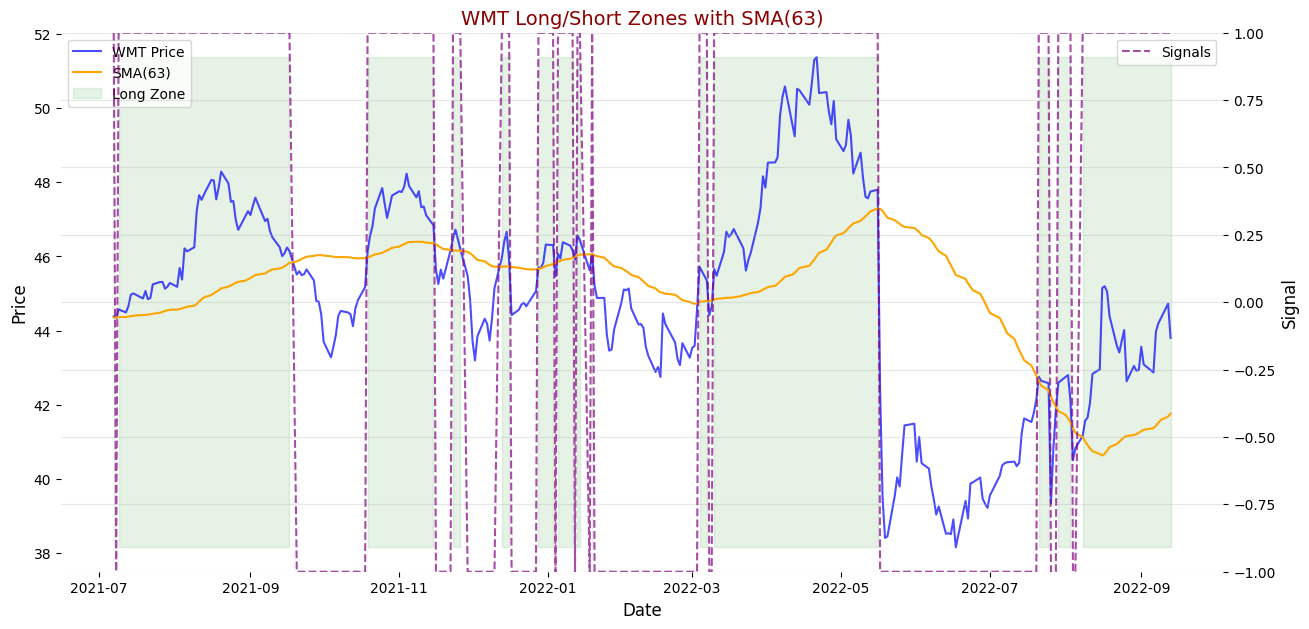

In [13]:
wmt_ma63_signals = (
    sma_price_signals(wmt.WMT, 63, plot=True, plot_window=300, strategy='long', name='WMT'))

In [14]:
wmt['Signals'] =  wmt_ma63_signals
wmt.head(3)

Tickers,WMT,Signals
Date,,
2014-10-13,21.094612,-1
2014-10-14,21.208851,-1
2014-10-15,20.452749,-1


In [15]:
wmt_calc = (
    strategy_calculation(wmt.reset_index(), date_col='Date', signal_col='Signals', 
                         price_col='WMT', strategy='long_only') )
wmt_calc.head(3)

Tickers,WMT,Signals,Price Return,Price Cum Return,Strategy Return,Strategy Cum Return,High Watermark,Drawdown,Max Drawdown
Date,,,,,,,,,
2014-10-13,21.094612,-1,0.000000,1.000000,0.0,1.0,1.0,0.0,0.0
2014-10-14,21.208851,-1,0.005401,1.005416,0.0,1.0,1.0,0.0,0.0
2014-10-15,20.452749,-1,-0.036301,0.969572,-0.0,1.0,1.0,0.0,0.0


In [16]:
strategy_metrics(wmt.reset_index(), date_col='Date', signal_col='Signals', price_col='WMT', 
                     strategy='long_only', drawdown='current', timeframe = 1)

Sharpe Ratio: 0.03
CAGR: 0.54%
Maximum Drawdown: -69.28%
Ongoing Drawdown Period (to current date): 652 days, 0:00:00


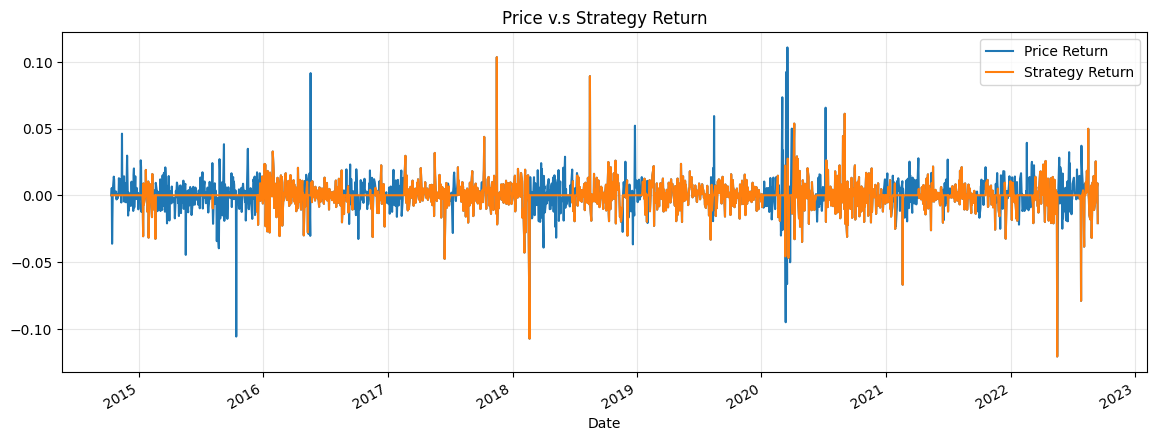

In [17]:
wmt_calc[['Price Return','Strategy Return']].plot(figsize = (14,5))
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('Price v.s Strategy Return');

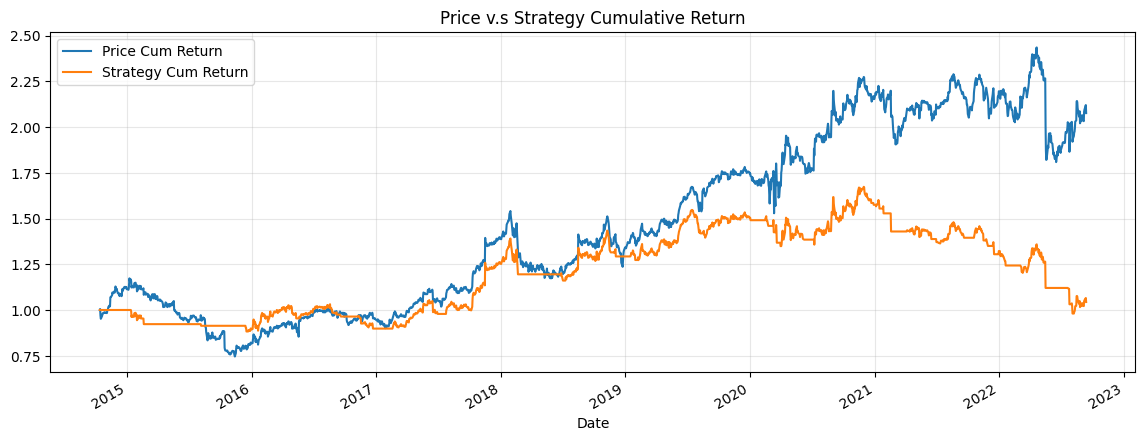

In [18]:
wmt_calc[['Price Cum Return','Strategy Cum Return']].plot(figsize = (14,5))
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('Price v.s Strategy Cumulative Return');

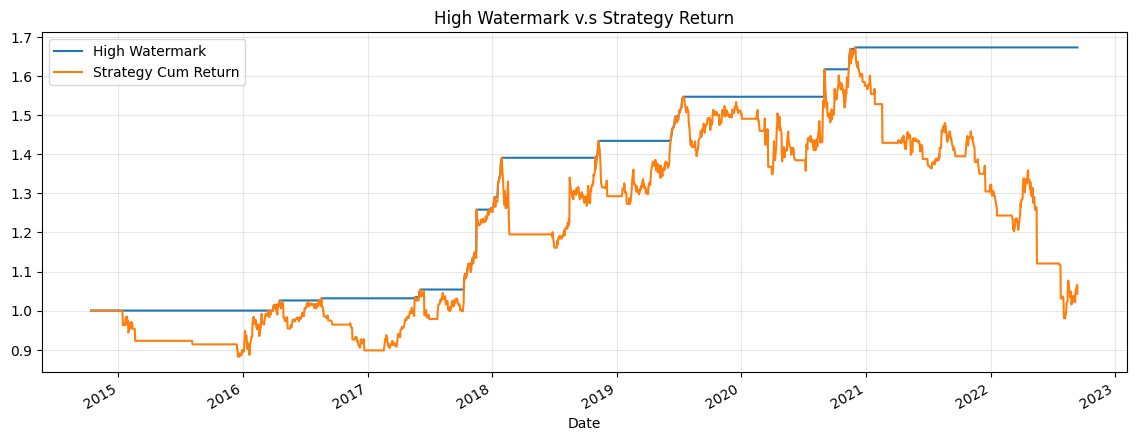

In [19]:
wmt_calc[['High Watermark','Strategy Cum Return']].plot(figsize = (14,5))
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('High Watermark v.s Strategy Return');

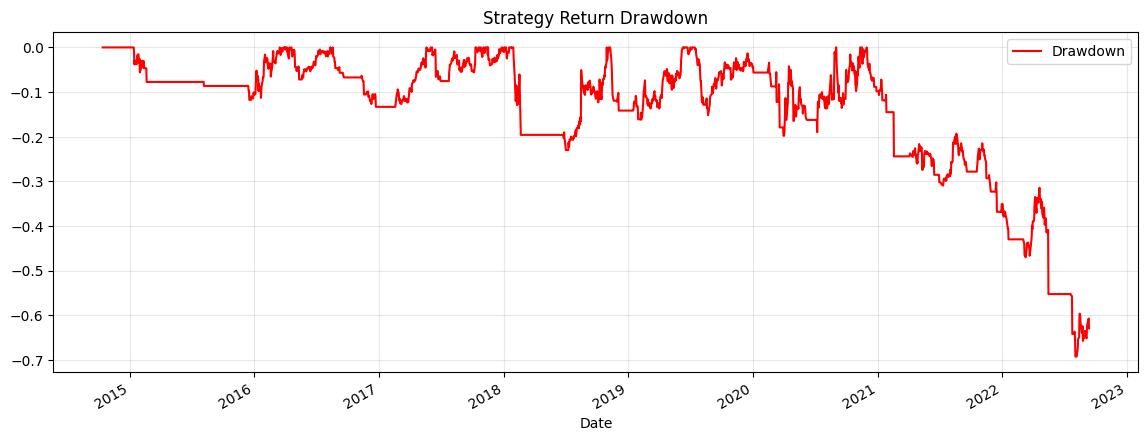

In [20]:
wmt_calc[['Drawdown']].plot(figsize = (14,5), color = 'red')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('Strategy Return Drawdown');

## Using `IBM` for the Double MA(20, 63) Crossover Strategy

In [22]:
def sma_double_signals(price, shorter_window, longer_window, plot=False, plot_window=None, strategy='long_short',
                      short_ma_name='21D', long_ma_name='50D', y_name='AMZN'):
    """
    Generate signals based on the relationship between two moving averages (short and long),
    with optional shaded areas for buy (long) and sell (short) regions.

    Parameters:
    price (pd.Series): The Series of prices for plotting purposes.
    shorter_window (int): The window to calculate Shorter SMA.
    longer_window (int): The window to calculate Longer SMA.
    plot (bool): If True, plots the price, moving averages, and shaded signal areas.
    plot_window (int, optional): Number of recent values to plot. If None, plots all values.
    signals (str): Type of signals to display on plot. Options are:
                   'long' for buy signals only,
                   'short' for sell signals only,
                   'long_short' for both buy and sell signals,
                   False (or None) for no signals.
    short_ma_name (str): Name of the shorter moving average for plot labeling.
    long_ma_name (str): Name of the longer moving average for plot labeling.
    y_name (str): Name of the price series for plot labeling.

    Returns:
    pd.Series: A Series with the same index as the moving averages, containing signal values:
               1 for long/buy area, and -1 for short/sell area.
    """
    # Calculate Shorter and Longer SMA
    short_ma = price.rolling(window = shorter_window).mean()
    long_ma = price.rolling(window = longer_window).mean()
    
    # Generate signals based on the relationship between short_ma and long_ma
    signals_series = pd.Series(
        np.where(short_ma > long_ma, 1, -1),
        index=short_ma.index,
        name=f'{y_name}_Signal'
    )
    
    # Plot if plot=True
    if plot:
        # Define the plotting range based on plot_window
        plot_data = price if plot_window is None else price[-plot_window:]
        plot_short_ma = short_ma if plot_window is None else short_ma[-plot_window:]
        plot_long_ma = long_ma if plot_window is None else long_ma[-plot_window:]
        plot_signals = signals_series if plot_window is None else signals_series[-plot_window:]

        # Plot price and moving averages
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(plot_data, label=y_name, color='grey', alpha=0.7)
        ax.plot(plot_short_ma, label=f'MA-{short_ma_name}', color='blue')
        ax.plot(plot_long_ma, label=f'MA-{long_ma_name}', color='orange')

        # Secondary y-axis for signals
        ax2 = ax.twinx()
        ax2.plot(plot_signals, color='purple', linestyle='--', label='Signals', alpha=0.7)
        ax2.set_ylim([-1, 1])  # Limits for signals (-1, 0, 1)

        # Shade regions based on the `signals` parameter
        if strategy == 'long_short' or strategy == 'long':
            ax.fill_between(plot_data.index, plot_data.min(), plot_data.max(),
                            where=(plot_signals == 1), color='green', alpha=0.1, label='Long Zone')
        if strategy == 'long_short' or strategy == 'short':
            ax.fill_between(plot_data.index, plot_data.min(), plot_data.max(),
                            where=(plot_signals == -1), color='red', alpha=0.1, label='Short Zone')

        # Remove the plot borders (spines) for both axes
        for spine in ax.spines.values():
            spine.set_visible(False)
        for spine in ax2.spines.values():
            spine.set_visible(False)

        # Titles and labels
        plt.title(f'{y_name} and Double-MA({short_ma_name} vs {long_ma_name}) Crossover Zones', fontsize=14, color='darkred')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Price', fontsize=12)
        ax2.set_ylabel('Signal', fontsize=12)

        # Customize ticks and legends
        ax.tick_params(axis='both', labelsize=12)
        ax.legend(loc="upper left")
        ax2.legend(loc="upper right")
        plt.grid(True, alpha=0.3)
        plt.show()

    return signals_series

In [23]:
ibm = df[['IBM']]
ibm.head(3)

Tickers,IBM
Date,
2014-10-13,114.104881
2014-10-14,114.278946
2014-10-15,113.004379


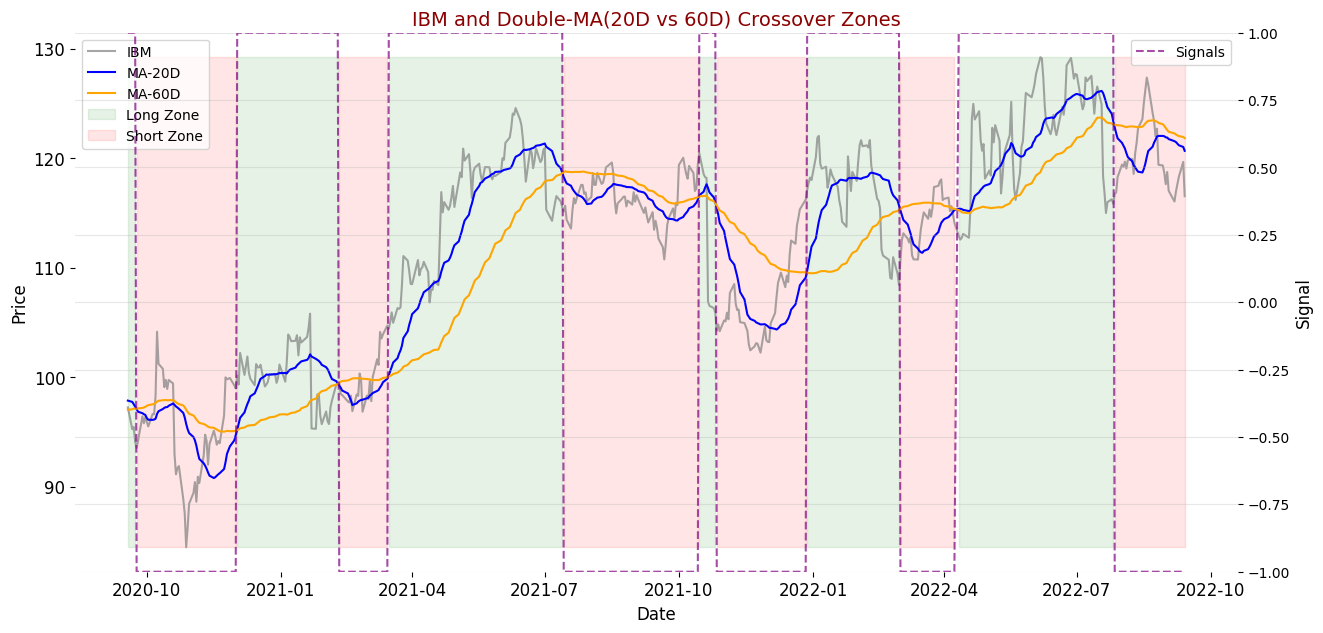

In [24]:
ibm_double_ma_signals = (
    sma_double_signals(ibm.IBM, 20, 60, plot=True, plot_window=500, strategy='long_short',
                      short_ma_name='20D', long_ma_name='60D', y_name='IBM'))

In [25]:
ibm['Signals'] = ibm_double_ma_signals
ibm = ibm[60:]
ibm.head(3)

Tickers,IBM,Signals
Date,,
2015-01-08,99.172943,-1
2015-01-09,99.604858,-1
2015-01-12,97.933403,-1


In [26]:
ibm_calc = (
    strategy_calculation(ibm.reset_index(), date_col='Date', signal_col='Signals', 
                         price_col='IBM', strategy='long_short') )
ibm_calc.head(3)

Tickers,IBM,Signals,Price Return,Price Cum Return,Strategy Return,Strategy Cum Return,High Watermark,Drawdown,Max Drawdown
Date,,,,,,,,,
2015-01-08,99.172943,-1,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN
2015-01-09,99.604858,-1,0.004346,1.004355,-0.004346,0.995664,0.995664,0.0,0.0
2015-01-12,97.933403,-1,-0.016923,0.987501,0.016923,1.012657,1.012657,0.0,0.0


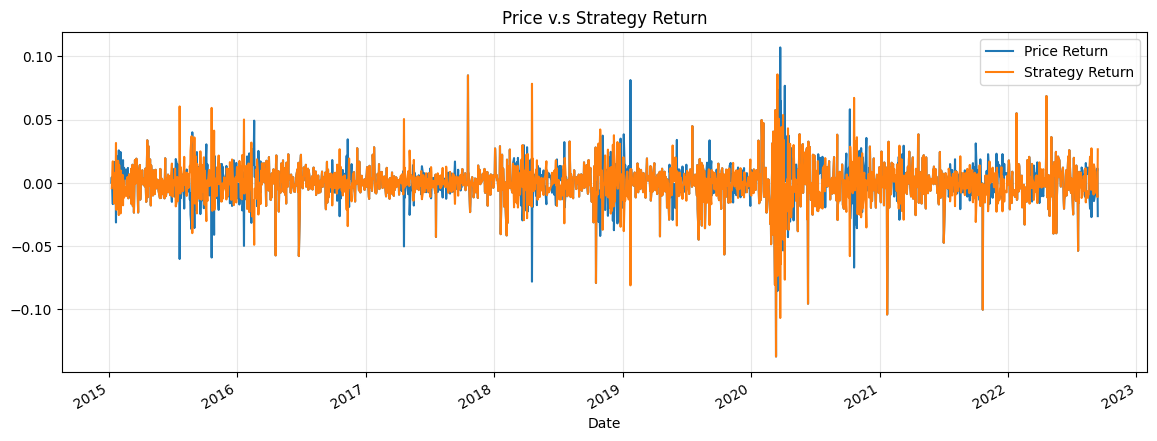

In [27]:
ibm_calc[['Price Return','Strategy Return']].plot(figsize = (14,5))
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('Price v.s Strategy Return');

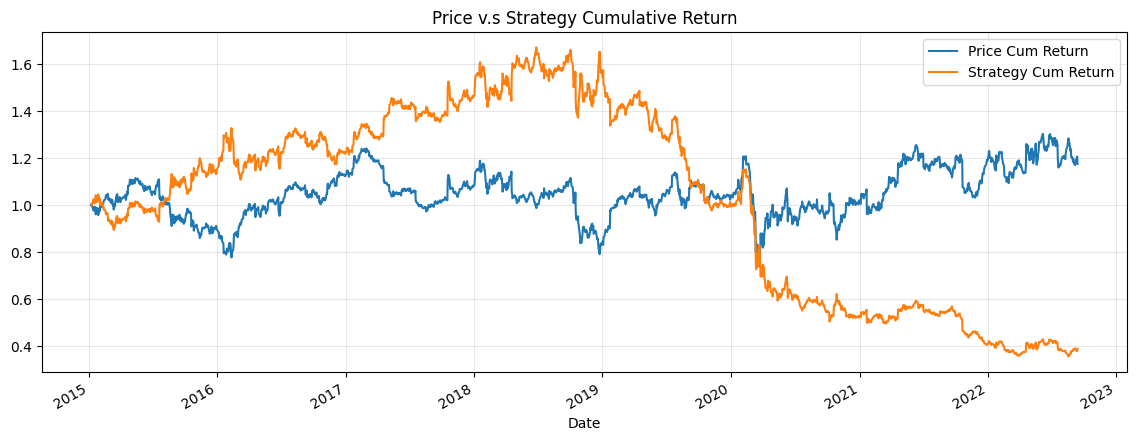

In [28]:
ibm_calc[['Price Cum Return','Strategy Cum Return']].plot(figsize = (14,5))
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('Price v.s Strategy Cumulative Return');

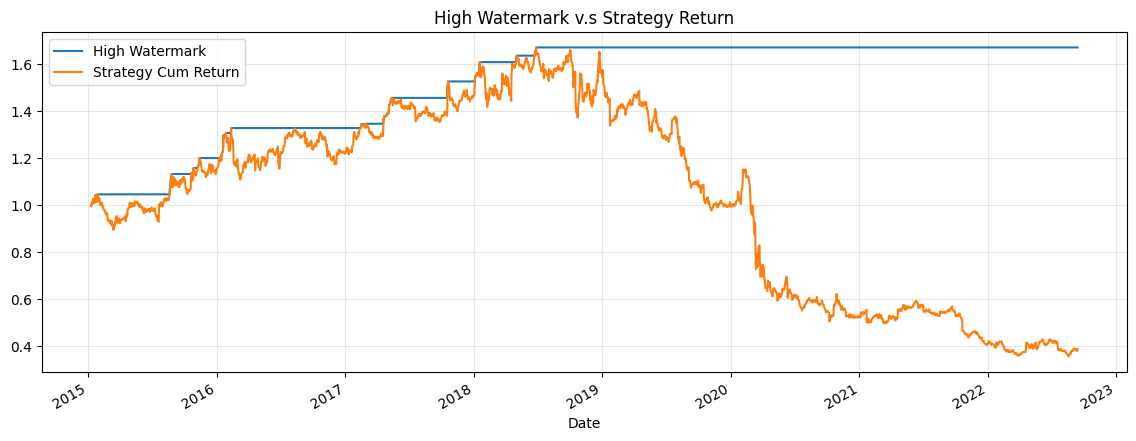

In [29]:
ibm_calc[['High Watermark','Strategy Cum Return']].plot(figsize = (14,5))
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('High Watermark v.s Strategy Return');

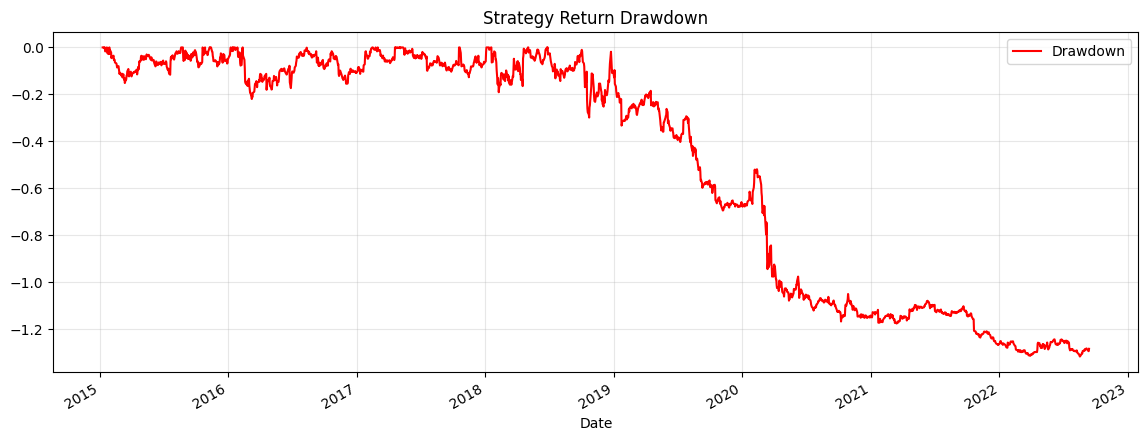

In [30]:
ibm_calc[['Drawdown']].plot(figsize = (14,5), color = 'red')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.title('Strategy Return Drawdown');

In [31]:
strategy_metrics(ibm.reset_index(), date_col='Date', signal_col='Signals', price_col='IBM', 
                     strategy='long_short', drawdown='current', timeframe = 1)

Sharpe Ratio: -0.50
CAGR: -11.63%
Maximum Drawdown: -131.82%
Ongoing Drawdown Period (to current date): 1539 days, 0:00:00


* <B>HINT: THERE IS ONE CRUCIAL THING THAT MUST BE DO WHEN CONSTRUCTING THIS STRATEGY (AND EVERY STRATEGY). IT SHOULD NOT BE AS BAD AS DISPLAYED ABOVE. I LEAVE IT TO YOU :)<B>